# Intoduction
The ECG project is about the development of automated methods to predict mortality based on ECG readings from SHL mobile devices, taken by unprofessional customers. It is consisted of several stages:  
1. Filter out noisy signals. This stage includes all the preprocessing we did, which will not be covered in this notebook.  
2. Develop a learning algorithm predict mortality from cleaned ECG readings.  
In this file, compare several learning algorithms and replicate [Xu and Liu (2019)](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8952723)'s 1D CNN model. I use a toy problem - identify from each lead a reading was taken, `V1` or `V5`.  


# Setup

In [ ]:
# Load packages
import numpy as np
import pandas as pd
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import copy

import matplotlib.pyplot as plt
import math
import os
from sklearn import preprocessing
from sklearn.utils import shuffle

%load_ext google.colab.data_table
from google.colab import data_table
import seaborn as sns

# Set options and load file
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Mount drive
from google.colab import drive
drive.mount('/content/drive')

# Load data
os.chdir("/content/drive/Shareddrives/ECG_research/data/preprocessed/DownloadAllSignals/until94755/")
df = pd.read_csv('likeli_rescaled_David_110621.csv')
df.drop(['Unnamed: 0', 'length', 'std', 'std_log', 'likeli', 'is_likeli'], axis = 1, inplace=True)

# Filter only V1 and V5 and create a binary variables
df = shuffle(df)
df = df[(df['Lead'] == 'V1') | \
        (df['Lead'] == 'V5')] 
df['target'] = 0.0
df['target'][df['Lead'] == 'V5'] = 1.0
df.drop(['Lead'], axis = 1, inplace = True)
df.iloc[0:10]

Mounted at /content/drive


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,target
14137,0.005,-0.005,-0.003,-0.011,-0.021,-0.026,-0.033,-0.037,-0.033,-0.031,-0.031,-0.032,-0.042,-0.057,-0.076,-0.097,-0.118,-0.133,-0.144,-0.150,-0.152,-0.151,-0.149,-0.147,-0.147,-0.153,-0.163,-0.174,-0.185,-0.194,-0.200,-0.205,-0.208,-0.206,-0.201,-0.193,-0.183,-0.174,-0.168,-0.164,...,0.257,0.255,0.246,0.232,0.214,0.197,0.182,0.170,0.161,0.158,0.156,0.157,0.158,0.156,0.151,0.145,0.137,0.129,0.122,0.114,0.106,0.101,0.094,0.088,0.085,0.082,0.078,0.075,0.070,0.065,0.065,0.067,0.067,0.073,0.075,0.069,0.068,0.067,0.041,0.000
8631,0.117,0.123,0.120,0.124,0.100,0.086,0.054,0.032,-0.004,-0.035,-0.072,-0.101,-0.121,-0.127,-0.123,-0.124,-0.125,-0.134,-0.139,-0.152,-0.155,-0.149,-0.134,-0.126,-0.128,-0.136,-0.149,-0.169,-0.198,-0.227,-0.256,-0.277,-0.289,-0.291,-0.287,-0.281,-0.277,-0.273,-0.267,-0.259,...,0.012,0.004,-0.004,-0.004,0.005,0.019,0.029,0.025,0.017,0.004,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.002,0.000,0.002,-0.000,0.002,0.000,0.002,0.001,0.001,0.001,0.000,0.003,-0.001,0.004,-0.002,0.005,-0.004,0.007,-0.005,0.009,0.000
18045,-0.015,-0.017,-0.014,-0.013,-0.015,-0.015,-0.013,-0.014,-0.014,-0.014,-0.013,-0.014,-0.013,-0.013,-0.012,-0.013,-0.014,-0.015,-0.018,-0.020,-0.020,-0.019,-0.017,-0.015,-0.013,-0.012,-0.012,-0.012,-0.012,-0.012,-0.010,-0.008,-0.005,-0.003,-0.001,-0.000,0.000,0.000,0.000,0.000,...,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.006,0.005,0.004,0.005,0.006,0.004,0.004,0.007,0.006,-0.003,1.000
16088,0.025,0.024,0.022,0.027,0.023,0.027,0.023,0.026,0.024,0.027,0.027,0.025,0.016,0.004,-0.002,0.001,0.013,0.021,0.027,0.026,0.026,0.024,0.024,0.023,0.027,0.034,0.041,0.045,0.048,0.056,0.064,0.070,0.071,0.071,0.065,0.052,0.036,0.022,0.011,-0.000,...,0.105,0.082,0.060,0.039,0.018,0.000,-0.015,-0.032,-0.046,-0.056,-0.058,-0.059,-0.058,-0.057,-0.054,-0.051,-0.051,-0.055,-0.060,-0.062,-0.064,-0.061,-0.054,-0.044,-0.041,-0.043,-0.045,-0.043,-0.039,-0.034,-0.024,-0.020,-0.014,-0.015,-0.008,-0.010,-0.005,-0.017,-0.022,1.000
10485,0.119,0.177,0.123,0.086,0.113,0.141,0.125,0.101,0.105,0.115,0.098,0.070,0.060,0.058,0.038,0.006,-0.016,-0.027,-0.049,-0.080,-0.100,-0.105,-0.111,-0.120,-0.115,-0.089,-0.056,-0.021,0.025,0.088,0.155,0.216,0.280,0.351,0.422,0.482,0.536,0.593,0.646,0.685,...,-0.077,-0.074,-0.079,-0.082,-0.081,-0.083,-0.096,-0.109,-0.113,-0.114,-0.122,-0.128,-0.123,-0.114,-0.118,-0.128,-0.130,-0.131,-0.146,-0.169,-0.183,-0.188,-0.205,-0.231,-0.243,-0.238,-0.242,-0.265,-0.277,-0.268,-0.271,-0.304,-0.326,-0.303,-0.282,-0.322,-0.369,-0.296,-0.085,0.000
21133,0.000,0.005,-0.000,-0.008,-0.010,-0.010,-0.010,-0.003,0.001,-0.004,-0.011,-0.012,-0.007,-0.001,-0.000,-0.007,-0.013,-0.014,-0.009,-0.003,-0.002,-0.002,-0.003,-0.010,-0.016,-0.017,-0.012,-0.006,-0.005,-0.013,-0.018,-0.013,-0.002,0.002,-0.005,-0.011,-0.004,0.017,0.032,0.035,...,0.011,0.022,0.033,0.038,0.032,0.025,0.025,0.027,0.027,0.022,0.016,0.007,0.002,0.003,0.004,0.006,0.008,0.003,-0.008,-0.012,-0.011,-0.002,0.012,0.011,-0.001,-0.009,-0.010,-0.002,0.012,0.022,0.015,0.005,0.005,0.007,0.008,0.011,0.008,-0.001,-0.005,1.000
15629,0.048,0.039,0.035,0.035,0.034,0.033,0.031,0.029,0.028,0.033,0.047,0.055,0.050,0.034,0.022,0.019,0.020,0.019,0.018,0.016,0.018,0.029,0.047,0.065,0.075,0.070,0.058,0.039,0.014,-0.015,-0.038,-0.048,-0.046,-0.038,-0.026,-0.021,-0.024,-0.028,-0.029,-0.029,...,-0.013,-0.012,-0.012,-0.011,-0.011,-0.010,-0.010,-0.009,-0.008,-0.007,-0.007,-0.006,-0.006,-0.005,-0.004,-0.003,-0.003,-0.002,-0.002,-0.001,-0.001,-0.001,-0.001,-0.001,-0.001,-0.001,-0.001,-0.001,-0.001,-0.001,-0.001,-0.001,-0.001,-0.000,-0.001,-0.000,-0.001,-0.000,-0.001,0.000

## Explore Data


In [ ]:
df['target'].value_counts()

1.000    16955
0.000    15710
Name: target, dtype: int64

[[<matplotlib.lines.Line2D at 0x7fc21773a850>],

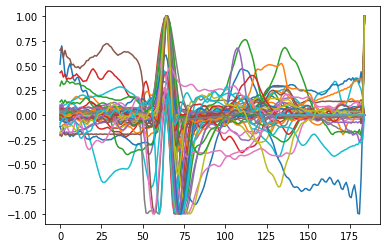

In [ ]:
[plt.plot(df.iloc[j].values) for j in range(50,100)]

The plot above shows 50 random signals. We see that in most caes, the R complex appears between 50-75, as expected, but there are cases in which it is not. Moreover, we see that the signals are normalized between 0 and 1, correctly.  
In the following two plots, we show 50 signals from each lead.

[[<matplotlib.lines.Line2D at 0x7fc214e78510>],

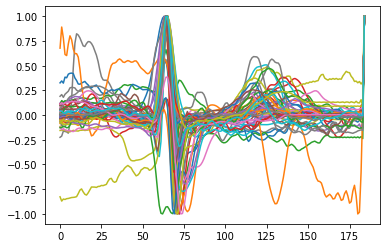

In [ ]:
[plt.plot(df[df['target'] == 1.0].reset_index(drop = True).\
          iloc[j].values) for j in range(50,100)]

[[<matplotlib.lines.Line2D at 0x7fc214d1b8d0>],

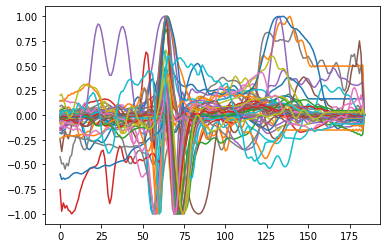

In [ ]:
[plt.plot(df[df['target'] == 0.0].reset_index(drop = True).\
          iloc[j].values) for j in range(50,100)]

While in both leads the majority of signals show expected pattern with R/S complex between 5-70, there are also significant mass of signals with noisy behaviour.  
Using the medical team's tags later may be helpful in removing these signals. **It is important to note that these signals are those that scored enough in the Likelihood test.**

## Train-Cross Validation and Test Splits

In [ ]:
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Train-CV-Test split
train_df, val_df = train_test_split(
  df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33, 
  random_state=RANDOM_SEED
)

X_train = train_df.drop(['target'], axis = 1)
y_train = train_df.filter(items = ['target'])
X_cv = val_df.drop(['target'], axis = 1)
y_cv = val_df.filter(items = ['target'])
X_test = test_df.drop(['target'], axis = 1)
y_test = test_df.filter(items = ['target'])

print('X_train:', X_train.shape)
print('X_cv:', X_cv.shape)
print('X_test:', X_test.shape)


X_train: (27765, 184)
X_cv: (3283, 184)
X_test: (1617, 184)


## Create a Data Loader
Since both `Pytorch` and `Tensorflow` work with tensors, we have to transform our data (which is in pandas/numpy format) into tensors. Moreover, deep learning models usually take one batch as an input, make a step, and proceed to the next one. Therefore, our data-loader function has to take a data frame as an input and return a list of sequences to be used as inputs for which model we would be using.  


In [ ]:
# example 
#sequences = df.astype(np.float32).to_numpy().tolist() # turn df into a list of lists
#dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences] # turn each list into a column vector. Overall, we get a list of column vectors (tensors)
#torch.stack(dataset).shape # stack tensors on one another, = torch.Size([4004 , 185, 1])

#n_seq, seq_len, n_features = torch.stack(dataset).shape

def create_dataset(df_X, y):

  sequences = df_X.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  y_ = torch.tensor(y.astype(np.float32).to_numpy().tolist()).unsqueeze(1)

  return dataset, seq_len, n_features, y_

train_dataset, seq_len, n_features, train_targets = create_dataset(X_train, y_train)
val_dataset, _, _, val_targets = create_dataset(X_cv, y_cv)
test_dataset, _, _, test_targets = create_dataset(X_test, y_train)

print(f'X:: train: {len(train_dataset)}, validation: {len(val_dataset)}, test: {len(test_dataset)}')
print(f'y:: train: {train_targets.shape}, validation: {val_targets.shape}, test: {test_targets.shape}')
print(f'seq_len: {seq_len}, n_features: {n_features}')
# train_dataset is a list of tensors, each tensor is a column vector with 184 rows and 1 colums.

torch.stack(train_dataset).shape # list of tensors to torch 3d
#####################################

X:: train: 27765, validation: 3283, test: 1617
y:: train: torch.Size([27765, 1, 1]), validation: torch.Size([3283, 1, 1]), test: torch.Size([27765, 1, 1])
seq_len: 184, n_features: 1


torch.Size([27765, 184, 1])

# Models
The problem we face is how to separate leads `V1` from `V5`. This is a toy problem that is meant to be a proof of concept for later use of the same tools developed in this notebook.  
We may also take advantage of the large amount of labeled data we have available (regarding which lead it refers to), we may use it to train a deep model and then apply it to other targets (say, to check if there is a cardiac condition or whether the lead is OK and not too noisy).  
In the following section we develop two deep learning models (vanilla LSTM) and 1DCNN. Lastly, we compare their results with an XGBoost classifier.  

## Xu and Liu (2019)
The 1-dimmentional CNN we use was proposed by [Xu and Liu (2019)](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8952723). Their model can be presented as the following schematic architecture:  

<figure>
<center>
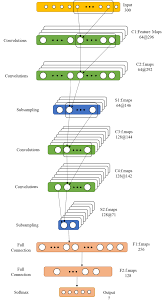
<figcaption>Xu and Liu (2019) 1D-CNN</figcaption></center>
</figure>

In their study, they used the MIT-BIH arrhythmia database. 
First they removed noise from the gross data using wavelet filters (Daubechies wavelet 6 (db6) to six levels and the wavelet
coefficients from 3rd level to 6th level were retained and used
for reconstructing the signal). Then, they used the R-complex notations to split their signals into lengths of 300, with R complexes in the middle.  
We use the same network in our replication, but with our SHL data and with Leads as an output, instead of cardiac conditions.  




The model consists of four convolusional layers (in green) followed with Relu functions. After each two convolusion-Relu layers, there is a sabsampling layer using [maxpool](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool1d.html) with window (kernel) of 2.  
Finaly, there are three fully connected layers, and a softmax activision function to get probabilities.  


In [ ]:

class HeartNetIEEE(torch.nn.Module):
    def __init__(self, num_classes=2):
      super().__init__()

      # 1 means that the input have to be a row tensors.
      self.conv1 = torch.nn.Conv1d(1, 64, 5, stride=2)
      self.conv2 = torch.nn.Conv1d(64, 64, 5, stride=2)
      self.conv3 = torch.nn.Conv1d(64, 128, kernel_size=3)
      self.conv4 = torch.nn.Conv1d(128, 128, kernel_size=3)
      self.relu  = torch.nn.ReLU()
      self.maxpool1d_2 = torch.nn.MaxPool1d(2)

      self.linear1 = torch.nn.Linear(128 * 8, 256) # 128 * 28, 256
      self.linear2 = torch.nn.Linear(256, 128)
      self.linear3 = torch.nn.Linear(128, num_classes)

    def forward(self, x):
      x = self.conv1(x)
      x = self.relu(x)
      x = self.conv2(x)
      x = self.maxpool1d_2(x)
      x = self.conv3(x)
      x = self.relu(x)
      x = self.conv4(x)
      x = self.relu(x)
      x = self.maxpool1d_2(x)
      x = x.reshape((batch_size, 128 * 8)) # I added this line
      x = self.linear1(x)
      x = self.linear2(x)
      x = self.linear3(x)
      return x    
    




## Vanilla LSTM
We compair our results with an LSTM and with XGB. In this part we develop the first. 

In [ ]:
# Vanilla LSTM
class ECG_Vanilla_LSTM(torch.nn.Module):
    def __init__(self,n_features, hidden_size, num_layers, dropout):
        super(ECG_Vanilla_LSTM, self).__init__()
        self.input_size = n_features
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
    
        self.l_lstm = torch.nn.LSTM(
                input_size = self.input_size, 
                hidden_size = self.hidden_size,
                num_layers = self.num_layers, 
                batch_first = True,
                dropout = self.dropout)
            
        self.tanh = torch.nn.Tanh()
        self.softmax = torch.nn.Softmax()
        self.linear = torch.nn.Linear(seq_len*hidden_size, n_features)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()


    def init_hidden(self, batch_size):
        self.hidden_layer = (torch.zeros(self.num_layers,batch_size,self.hidden_size).to(device),torch.zeros(self.num_layers,batch_size,self.hidden_size).to(device))
    
    def forward(self, x):
      x, self.hidden_layer = self.l_lstm(x, self.hidden_layer) # torch.stack(train_dataset[0:batch]) x is a list at first
      x = x.reshape(batch_size, -1)
      x = self.linear(x)
      #x = self.tanh(x)
      x = self.sigmoid(x)

      self.hidden_layer = [elem.detach_() for elem in self.hidden_layer]

      return x


## XGBoost
In contrast with the other classifiers presented in this notebook, XGBoost is the only one that does not require tensors as input and is shallow and uses boosting trees rather than NN.  
In contrast with the rest, it also does not requires a trainer and is relatively easy to use. Therefore, we cover it in the estimation part, after we develop our trainer functions.

## Trainers and Post-Estimation

In [ ]:

def train_model_LSTM(train_dataset, train_targets, val_dataset, val_targets, batch_size, params, learning_rate = 0.001, n_epochs = 50):
  
  history = dict({
      'learning_rate': [],
      'batch_size': [],
      'n_epochs': [],
      'num_hidden_layers': [], 
      'num_layers': [],
      'dropout': [],
      'train_mse':[], 
      'validation_mse':[]})

  
  best_loss = 10000.0
  
  # for each hyper-paramers combination:
  for lr in params['lr']:
    for hddnsz in params['hddnsz']:
      for nmlrs in params['nmlrs']: 
        for dpt in params['dpt']:
          
          model = ECG_Vanilla_LSTM(n_features=n_features,
                                hidden_size = hddnsz, 
                                num_layers = nmlrs,
                                dropout = dpt)
          model.init_hidden(batch_size=batch_size)
          model.to(device)
          
          criterion = torch.nn.BCELoss().to(device)
          optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

          best_model_wts = copy.deepcopy(model.state_dict())

          # start training
          for epoch in range(1, n_epochs + 1):
            # Set the model on a training phase
            model = model.train()
            model = model.to(device)

            train_losses = []
            batch_idx = 0
            while batch_idx+batch_size <= len(train_dataset):
              
              # draw examples
              Xtemp = torch.stack(train_dataset[batch_idx:(batch_idx+batch_size)]).to(device)
              ytemp = train_targets[batch_idx:(batch_idx+batch_size)].to(device)
              batch_idx += batch_size

              optimizer.zero_grad()

              output = model(Xtemp)
                    
              loss = criterion(output.view(-1), ytemp.view(-1))
              loss.backward()
              optimizer.step()

              train_losses.append(loss.item())

            val_losses = []
            model = model.eval()
            with torch.no_grad():
              batch_idx = 0
              while batch_idx + batch_size<len(val_dataset):
                
                # draw examples
                Xtemp = torch.stack(val_dataset[batch_idx:(batch_idx+batch_size)]).to(device)
                ytemp = val_targets[batch_idx:(batch_idx+batch_size)].to(device)
                batch_idx += batch_size
                      
                output = model(Xtemp)
                loss = criterion(output.view(-1), ytemp.view(-1))
                val_losses.append(loss.item())

            train_loss = np.mean(train_losses)
            val_loss = np.mean(val_losses)

            # Save values to dict
            history['train_mse'].append(train_loss)
            history['validation_mse'].append(val_loss)
            history['learning_rate'].append(learning_rate)
            history['batch_size'].append(batch_size)
            history['n_epochs'].append(n_epochs)
            history['num_hidden_layers'].append(hddnsz)
            history['num_layers'].append(nmlrs)
            history['dropout'].append(dpt)


            # Update best model if necessary
            if val_loss < best_loss:
              best_loss = val_loss
              best_model_wts = copy.deepcopy(model.state_dict())
              torch.save(model.state_dict(), "/content/drive/Shareddrives/ECG_research/Output/models/Vanillalstm.pth")

            print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}. Best loss yet is {best_loss}..')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

def train_model_Heartnet(train_dataset, train_targets, val_dataset, val_targets, batch_size, params, num_classes = 2, learning_rate = 0.001, n_epochs = 50):
  
  history = dict({
      'learning_rate': [],
      'batch_size': [],
      'n_epochs': [],
      'train_mse':[], 
      'validation_mse':[]})

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  #device = 'cpu'
  best_loss = 10000.0
  
  # for each hyper-paramers combination:
  for lr in params['lr']:
    
    model = HeartNetIEEE(num_classes=num_classes).to(device)
    sig = torch.nn.Sigmoid().to(device)
    
    if num_classes == 1:
      criterion = torch.nn.BCELoss().to(device)
    else:
      criterion = torch.nn.CrossEntropyLoss().to(device)
    
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    best_model_wts = copy.deepcopy(model.state_dict())

    # start training
    for epoch in range(1, n_epochs + 1):
      # Set the model on a training phase
      model = model.train()
      #model = model.to(device)

      train_losses = []
      batch_idx = 0
      while batch_idx+batch_size <= len(train_dataset):
        
        # draw examples
        Xtemp = torch.stack(train_dataset[batch_idx:(batch_idx+batch_size)]).to(device)
        if num_classes == 1:
          ytemp = train_targets[batch_idx:(batch_idx+batch_size)].to(device)
        else:
          ytemp = train_targets[batch_idx:(batch_idx+batch_size)].type(torch.LongTensor).to(device)
        # reshape
        Xtemp = Xtemp.reshape((batch_size,Xtemp.shape[2],Xtemp.shape[1]))
        
        # update
        batch_idx += batch_size

        optimizer.zero_grad()

        output = model(Xtemp)

        if num_classes == 1:
          output = sig(output)
          loss = criterion(output.view(-1), ytemp.view(-1))
        else:
          loss = criterion(output, ytemp.view(-1))
        
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

      val_losses = []
      model = model.eval()
      with torch.no_grad():
        batch_idx = 0
        while batch_idx + batch_size<len(val_dataset):
          
          # draw examples
          Xtemp = torch.stack(val_dataset[batch_idx:(batch_idx+batch_size)]).to(device)
          if num_classes == 1:
            ytemp = val_targets[batch_idx:(batch_idx+batch_size)].to(device)
          else:
            ytemp = val_targets[batch_idx:(batch_idx+batch_size)].type(torch.LongTensor).to(device)

          # reshape
          Xtemp = Xtemp.reshape((batch_size,Xtemp.shape[2],Xtemp.shape[1]))
          # update
          batch_idx += batch_size
                
          output = model(Xtemp)
          
          if num_classes == 1:
            output = sig(output)
            loss = criterion(output.view(-1), ytemp.view(-1))
          else:
            loss = criterion(output, ytemp.view(-1))
          
          val_losses.append(loss.item())

      train_loss = np.mean(train_losses)
      val_loss = np.mean(val_losses)

      # Save values to dict
      history['train_mse'].append(train_loss)
      history['validation_mse'].append(val_loss)
      history['learning_rate'].append(lr)
      history['batch_size'].append(batch_size)
      history['n_epochs'].append(n_epochs)
      

      # Update best model if necessary
      if val_loss < best_loss:
        best_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), "/content/drive/Shareddrives/ECG_research/Output/models/HeartNet.pth")

      print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}. Best loss yet is {best_loss}..')

  model.load_state_dict(best_model_wts)
  return model.eval(), history
  

In [ ]:
# Confusion matrix for both models
def Binary_confussion_matrix(model, batch_size, data, targets, bound = 0.5):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = model.eval()
  with torch.no_grad():
    batch_idx = 0
    N = 0
    m0o0 = 0
    m1o1 = 0
    m0o1 = 0
    m1o0 = 0
      
    while batch_idx + batch_size < len(val_dataset):
      
      # draw examples
      Xtemp = torch.stack(val_dataset[batch_idx:(batch_idx+batch_size)]).to(device)
      ytemp = val_targets[batch_idx:(batch_idx+batch_size)].to(device)
      
      N += batch_size
      batch_idx += batch_size

      output = model(Xtemp).to('cpu').detach().numpy().reshape((batch_size,1))
      ytemp = ytemp.to('cpu').detach().numpy().reshape((batch_size,1))
      output[output >= bound] = 1
      output[output < bound] = 0

      m0o0 += np.sum((ytemp == output) & (output == 0))
      m1o1 += np.sum((ytemp == output) & (output == 1))
      m0o1 += np.sum((ytemp == 0) & (output == 1))
      m1o0 += np.sum((ytemp == 1) & (output == 0))

    confmat = pd.DataFrame(np.zeros((2,2)), columns = ['V1', 'V5'])
    confmat = pd.concat([confmat,pd.DataFrame(['V1', 'V5'])], axis = 1)
    confmat.set_index(0, inplace=True, drop = True)
    
    confmat.iloc[0,0] = m0o0
    confmat.iloc[0,1] = m0o1
    confmat.iloc[1,0] = m1o0
    confmat.iloc[1,1] = m1o1

    confmat_prob = confmat/N

  return confmat, confmat_prob

def Binary_confussion_matrix_Heartpy(model, batch_size, data, targets, bound = 0.5):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.to(device)
  sig = torch.nn.Sigmoid().to(device)

  model = model.eval()
  with torch.no_grad():
    batch_idx = 0
    N = 0
    m0o0 = 0
    m1o1 = 0
    m0o1 = 0
    m1o0 = 0
      
    while batch_idx + batch_size < len(val_dataset):
      
      # draw examples
      Xtemp = torch.stack(val_dataset[batch_idx:(batch_idx+batch_size)]).to(device)
      ytemp = val_targets[batch_idx:(batch_idx+batch_size)].type(torch.LongTensor).to(device)
      # reshape
      Xtemp = Xtemp.reshape((batch_size,Xtemp.shape[2],Xtemp.shape[1]))
      # update
          
      N += batch_size
      batch_idx += batch_size

      output = sig(model(Xtemp))
      #output = torch.argmax(output, dim = 1).to('cpu').detach().numpy().reshape((batch_size,1))
      ytemp = ytemp.to('cpu').detach().numpy().reshape((batch_size,1))
      output[output >= bound] = 1
      output[output < bound] = 0
      output=output.cpu().numpy()
      m0o0 += np.sum((ytemp == output) & (output == 0))
      m1o1 += np.sum((ytemp == output) & (output == 1))
      m0o1 += np.sum((ytemp == 0) & (output == 1))
      m1o0 += np.sum((ytemp == 1) & (output == 0))

    confmat = pd.DataFrame(np.zeros((2,2)), columns = ['V1', 'V5'])
    confmat = pd.concat([confmat,pd.DataFrame(['V1', 'V5'])], axis = 1)
    confmat.set_index(0, inplace=True, drop = True)
    
    confmat.iloc[0,0] = m0o0
    confmat.iloc[0,1] = m0o1
    confmat.iloc[1,0] = m1o0
    confmat.iloc[1,1] = m1o1

    confmat_prob = confmat/N

  return pd.DataFrame(confmat), pd.DataFrame(confmat_prob)


# Train

## XGBoost

In [ ]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# define the same loss function as in the LSTM
criterion = torch.nn.BCELoss().to(device)

dtrain = xgb.DMatrix(X_train.values, label=y_train.values)
dcv = xgb.DMatrix(X_cv.values, label=y_cv.values)

# define the same loss function as in the LSTM
criterion = torch.nn.BCELoss().to(device)
best_loss = 1000

dtrain = xgb.DMatrix(X_train.values, label=y_train.values)
dcv = xgb.DMatrix(X_cv.values, label=y_cv.values)

results_xgb = dict({
    'max_depth':[], 
    'eta':[], 
    'subsmple': [],
    'lambda': [],
    'alpha': [],
    'mse_loss': [],
    'val_acc':[]
})

bound = 0.5
best_acc = 0

# training an XGB tree
for lr in [0.1, 0.05, 0.01, 0.005, 0.001]:
  for mdpth  in [2,4,6,8]:
    for subsmple in [0.7, 0.8, 0.9, 1]:
      for lmbda in [10**elem for elem in list(range(-5,5))]:
        for alph in [10**elem for elem in list(range(-5,5))]:
                    
          param = {'max_depth':mdpth, 
                   'eta':lr, 
                   'subsmple': subsmple,
                   'lambda': lmbda,
                   'alpha': alph,
                   'objective':'binary:logistic',
                   'tree_method': 'gpu_hist'}

          model_XGB = xgb.train(param, dtrain)

          # make prediction
          preds = model_XGB.predict(dcv)
          preds = preds.reshape((preds.shape[0],1))
          preds_acc = preds.copy()
          preds = torch.tensor(preds.astype(np.float32).tolist()).unsqueeze(1)
          y_cv_tensor = torch.tensor(y_cv.astype(np.float32).to_numpy().tolist()).unsqueeze(1)

          # mse loss
          loss = criterion(preds, y_cv_tensor).item()

          # mse accuracy
          preds_acc[preds_acc >= bound] = 1
          preds_acc[preds_acc < bound] = 0
          acc = np.mean(preds_acc == y_cv.values)

          if loss < best_loss:
            results_xgb['max_depth'].append(mdpth) 
            results_xgb['eta'].append(lr) 
            results_xgb['subsmple'].append(subsmple)
            results_xgb['lambda'].append(lmbda)
            results_xgb['alpha'].append(alph)
            results_xgb['mse_loss'].append(loss)
            results_xgb['val_acc'].append(acc)
            best_acc = acc
            
            best_loss = loss
          
            print(f'XGBoost best Cross Validation loss so far is {loss}')
            
results_xgb_pd = pd.DataFrame.from_dict(results_xgb)
results_xgb_pd.to_csv('/content/drive/Shareddrives/ECG_research/Output/results_tables/Binary_classification_V1V5_XGB_benchmark.csv')

XGBoost best Cross Validation loss so far is 0.4325926899909973
XGBoost best Cross Validation loss so far is 0.40237635374069214
XGBoost best Cross Validation loss so far is 0.40235382318496704
XGBoost best Cross Validation loss so far is 0.3842005729675293
XGBoost best Cross Validation loss so far is 0.38408562541007996
XGBoost best Cross Validation loss so far is 0.37380680441856384
XGBoost best Cross Validation loss so far is 0.3737806975841522
XGBoost best Cross Validation loss so far is 0.37377452850341797
XGBoost best Cross Validation loss so far is 0.37186646461486816


In [ ]:
print(f'XGB accuracy is {best_acc}')

XGB accuracy is 0.8848614072494669


## LSTM
During the LSTM training, the GPU that google provides freely just shut down so I canceled the running.  
It achieved accuracy of 89.5% (at best).

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

params = dict({
    'lr': [0.001, 0.005, 0.01], # 
    'hddnsz': [6 , 8, 12], #
    'nmlrs': [2,4], # 
    'dpt': [0.5, 0.8, 0.9] # 
})
batch_size = 16

model, history = train_model_LSTM(
  train_dataset, 
  train_targets,
  val_dataset, 
  val_targets, 
  n_epochs=50,
  batch_size = 16,
  params = params
)

Epoch 1: train loss 0.6684808726097734 val loss 0.564960045930816. Best loss yet is 0.564960045930816..
Epoch 2: train loss 0.4064581559310729 val loss 0.3609173610443022. Best loss yet is 0.3609173610443022..
Epoch 3: train loss 0.3605924176852023 val loss 0.33917463011131055. Best loss yet is 0.33917463011131055..
Epoch 4: train loss 0.3526744462313501 val loss 0.33171464364703107. Best loss yet is 0.33171464364703107..
Epoch 5: train loss 0.34717552655669043 val loss 0.3274275111715968. Best loss yet is 0.3274275111715968..
Epoch 6: train loss 0.34087750289900504 val loss 0.32302264280435516. Best loss yet is 0.32302264280435516..
Epoch 7: train loss 0.33649146691909443 val loss 0.320015401992856. Best loss yet is 0.320015401992856..
Epoch 8: train loss 0.33421178804522633 val loss 0.3184590817951575. Best loss yet is 0.3184590817951575..
Epoch 9: train loss 0.33263038160649777 val loss 0.3182456111035696. Best loss yet is 0.3182456111035696..


KeyboardInterrupt: ignored

### Post Estimation

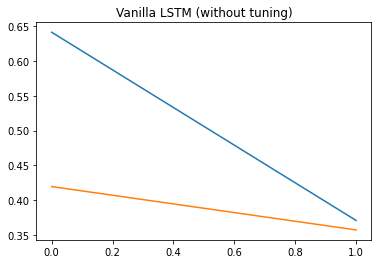

,V1,V5
0,,
V1,0.394,0.085
V5,0.058,0.463


In [ ]:
plt.plot(history['train_mse'])
plt.plot(history['validation_mse'])
plt.title('Vanilla LSTM (without tuning)')
plt.show()

conf, conf_prob = Binary_confussion_matrix(model = model, batch_size = batch_size, data = val_dataset, targets = val_targets, bound = 0.5)
conf_prob

## 1D-CNN

In [ ]:
batch_size = 16

params = dict({
    'lr': [0.01] # , 0.05, 0.01, 0.005, 0.001 
})

model, history = train_model_Heartnet(
  train_dataset,
  train_targets,
  val_dataset, 
  val_targets, 
  num_classes = 1, 
  n_epochs=20, 
  batch_size = 16,
  params = params
)

Epoch 1: train loss 0.6122599970968038 val loss 0.3763135121726408. Best loss yet is 0.3763135121726408..
Epoch 2: train loss 0.3272201438759177 val loss 0.29824642746186836. Best loss yet is 0.29824642746186836..
Epoch 3: train loss 0.2930471364269167 val loss 0.2777668633112093. Best loss yet is 0.2777668633112093..
Epoch 4: train loss 0.27691143191169937 val loss 0.26576895212254875. Best loss yet is 0.26576895212254875..
Epoch 5: train loss 0.2661304098159418 val loss 0.25567518418155066. Best loss yet is 0.25567518418155066..
Epoch 6: train loss 0.25816642735958617 val loss 0.24752187679817036. Best loss yet is 0.24752187679817036..
Epoch 7: train loss 0.2519815132086318 val loss 0.24193344172544595. Best loss yet is 0.24193344172544595..
Epoch 8: train loss 0.24679639289848054 val loss 0.23770739785054834. Best loss yet is 0.23770739785054834..
Epoch 9: train loss 0.24225099487095986 val loss 0.2339741886934129. Best loss yet is 0.2339741886934129..
Epoch 10: train loss 0.2384555

In [ ]:
_, conf_prob = Binary_confussion_matrix_Heartpy(model = model, batch_size = 16, data = val_dataset, targets = val_targets, bound=0.5)
print(f'1D CNN accuracy is {conf_prob.values[0,0] + conf_prob.values[1,1]}')

1D CNN accuracy is 0.9125000000000001


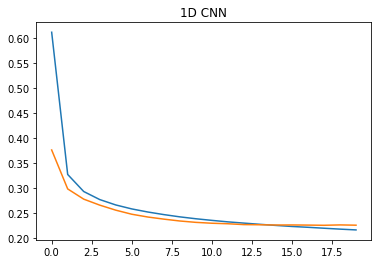

In [ ]:
plt.plot(history['train_mse'])
plt.plot(history['validation_mse'])
plt.title('1D CNN')
plt.show()

## Conclutions
In this paper I compaired few learning algorithms, in order to classify ECG readings to the leads by which they were taken. The results show that using 1D-CNN led to higher accuracy. 